# Exploring Neural Networks with the MNIST and EMNIST dataset
Here, we will explore neural networks under the MNIST and EMNIST dataset in order to get a good understanding of how accurate machine learning models can get, and what its limits are.

In [35]:
# IMPORTS

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Detect GPU so we can use hardware acceleration
# Prints cuda if using a GPU, prints cpu if we're just using a CPU

# Please note that you must install a version of pytorch
# that supports CUDA, and you must have an NVIDIA GPU

# CUDA:     https://developer.nvidia.com/cuda-downloads?target_os=Windows&target_arch=x86_64&target_version=11&target_type=exe_local
# PYTORCH:  https://pytorch.org/get-started/locally/

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [36]:
# SETUP OF PATHS AND CONSTANTS

batch_size_train = 64
batch_size_test = 1000

dir_dataset = "/files/"

PATH_DNN_MNIST = "dnn_model_mnist"
PATH_CNN_MNIST = "cnn_model_mnist"
PATH_CNN_EMNIST = "cnn_model_emnist"

def get_model_path(raw_path: str, hyperparameters):
    
    if (hyperparameters == []):
        return raw_path + ".pth"
    
    hyperparameters_str = \
        str(hyperparameters[0]) + "-" + \
        str(hyperparameters[1]) + "-" + \
        str(hyperparameters[2])
    return raw_path + hyperparameters_str.replace(".","_") + ".pth"

In [37]:
# SETUP OF DATASETS

# mnist

mnist_loader_train = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(dir_dataset, train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train, shuffle=True)

mnist_loader_test = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(dir_dataset, train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test, shuffle=True)

# emnist

emnist_loader_train = torch.utils.data.DataLoader(
    torchvision.datasets.EMNIST(dir_dataset, split='letters', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                                    lambda img: torchvision.transforms.functional.hflip(img),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train, shuffle=True)

emnist_loader_test = torch.utils.data.DataLoader(
    torchvision.datasets.EMNIST(dir_dataset, split='letters', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                                    lambda img: torchvision.transforms.functional.hflip(img),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test, shuffle=True)


In [60]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Define a custom Dataset class
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, img_path  # Return image and its path for identification

# Define transformations for the test images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean and std
])

# Specify the path to the test dataset
test_data_dir = "img/"

# Create the test dataset
test_dataset = TestDataset(root_dir=test_data_dir, transform=transform)

# Create the test DataLoader
batch_size = 6  # Adjust batch size as needed
custom_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the Test DataLoader
for images, paths in custom_loader:
    print(f"Batch size: {images.size(0)}, Image shape: {images.shape}")
    print(f"Paths: {paths}")
    break


Batch size: 6, Image shape: torch.Size([6, 1, 28, 28])
Paths: ('img/img01.png', 'img/img02.png', 'img/img03.png', 'img/img04.png', 'img/img05.png', 'img/img06.png')


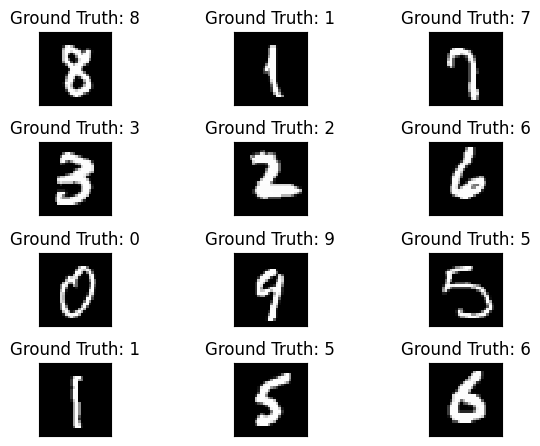

In [39]:
# DISPLAYING THE MNIST DATASET

mnist_label_map = [str(i) for i in range(10)]
mnist_labels_size = len(mnist_label_map)

# Get some test data
examples = enumerate(mnist_loader_test)
batch_idx, (example_data, example_targets) = next(examples)

# Plot the samples
fig = plt.figure()
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Ground Truth: {mnist_label_map[example_targets[i].item()]}")
    plt.xticks([])
    plt.yticks([])
plt.show()

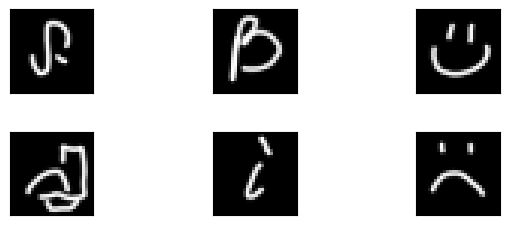

In [40]:
# DISPLAYING THE EMNIST DATASET

emnist_label_map = [0] + [chr(i) for i in range(ord('A'), ord('Z') + 1)]
emnist_labels_size = len(emnist_label_map)

# Get some test data
examples = enumerate(custom_loader)
batch_idx, (example_data, example_targets) = next(examples)

# Plot the samples
fig = plt.figure()
for i in range(6):
    plt.subplot(4, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [41]:
# DEFINING THE DEEP NEURAL NETWORK

class NetDNN(nn.Module):
    def __init__(self, labels_size):
        super(NetDNN, self).__init__()
        # Input size for MNIST images (28x28 = 784)
        self.input_size = 28 * 28
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.input_size, 512)  # Input to hidden layer 1
        self.bn1 = nn.BatchNorm1d(512)             # Batch normalization
        
        self.fc2 = nn.Linear(512, 256)             # Hidden layer 2
        self.bn2 = nn.BatchNorm1d(256)             # Batch normalization
        
        self.fc3 = nn.Linear(256, 128)             # Hidden layer 3
        self.bn3 = nn.BatchNorm1d(128)             # Batch normalization
        
        self.fc4 = nn.Linear(128, 64)              # Hidden layer 4
        self.bn4 = nn.BatchNorm1d(64)              # Batch normalization
        
        self.fc5 = nn.Linear(64, labels_size)      # Output layer for 10 classes
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Flatten input (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(-1, self.input_size)
        
        # Fully connected layers with ReLU, BatchNorm, and Dropout
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        
        # Output layer (logits)
        x = self.fc5(x)
        
        # Use log_softmax for classification output
        return F.log_softmax(x, dim=1)


In [42]:
# DEFINING THE CONVOLUTIONAL NEURAL NETWORK

class NetCNN(nn.Module):
    def __init__(self, labels_size):
        super(NetCNN, self).__init__()
        
        # First convolutional block: Conv -> BatchNorm -> ReLU -> MaxPool
        # First pass of classification
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.bn1 = nn.BatchNorm2d(32)
        
        # Second convolutional block: Conv -> BatchNorm -> ReLU -> MaxPool
        # 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.bn2 = nn.BatchNorm2d(64)
        
        # Dropout to prevent overfitting
        self.drop = nn.Dropout2d(0.25)
        
        # Third convolutional block: Conv -> BatchNorm -> ReLU -> MaxPool
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 14x14 -> 14x14
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 128)      # Adjust flattened size for pooling
        self.fc2 = nn.Linear(128, labels_size)      # Output layer

    def forward(self, x):
        # First conv block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)  # 28x28 -> 14x14
        
        # Second conv block
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)  # 14x14 -> 7x7
        
        # Dropout to prevent overfitting
        x = self.drop(x)
        
        # Third conv block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)  # 7x7 -> 3x3
        
        # Flatten for fully connected layers (from 128x3x3 to 1D)
        x = x.view(x.size(0), -1)  # Flatten tensor
        
        # Fully connected layers
        x = F.relu(self.fc1(x))  # FC1 + ReLU
        x = self.fc2(x)          # FC2
        
        # Log softmax for classification (probabilities)
        return F.log_softmax(x, dim=1)

In [56]:
# DEFINING FUNCTIONS FOR INITIALIZATION

# He initialization of weights

def weights_init(layer_in):
    if isinstance(layer_in, nn.Linear):
        nn.init.kaiming_uniform_(layer_in.weight)
        layer_in.bias.data.fill_(0.0)

# Main training routine

def train_model(model, train_loader, optimizer, epoch):
    model.train()
    epoch_batch_loss_array = []
    # Get each
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # Store results
        if batch_idx % 25 == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))
        epoch_batch_loss_array.append([epoch, batch_idx * len(data), loss.item()])
    return epoch_batch_loss_array

# Run on test data

def test_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    return 'Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset))

# Commence training routine

def run_and_train_model(model_path, model, train_loader, test_loader, n_epochs, learning_rate=0.01, momentum=0.5):
    # Initialize model weights
    model.apply(weights_init)
    # Define optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # Store epoch results in a string
    # that we can use to analyze average loss and accuracy
    epoch_results = ""
    # Store data we can use to graph
    epoch_batch_loss_array = []
    # Get initial performance
    epoch_results += test_model(model, test_loader)
    # Train for three epochs
    n_epochs = 3
    for epoch in range(1, n_epochs + 1):
        epoch_batch_loss_array += train_model(model, train_loader, optimizer, epoch)
        epoch_results += test_model(model, test_loader)

    torch.save(model, model_path)

    # --- GRAPHING THE RESULTS

    print(epoch_results)
    
    # Printing array is irrelevant since it will be used in the graph
    # print(epoch_batch_loss_array)

    # Extract batch numbers and loss values
    batch_numbers = [item[1] + (item[0]-1) * len(train_loader.dataset) for item in epoch_batch_loss_array]
    loss_values = [item[2] for item in epoch_batch_loss_array]

    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.xlim(-1000, 175000)
    plt.ylim(-0.5, 4)

    # Plot the loss values against batch numbers
    plt.plot(batch_numbers, loss_values, label='Training Loss')

    # Add labels and title
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

    # Return results and batch loss array for data, though
    # it now seems unnecessary due to the plot already being
    # there.
    return epoch_results, epoch_batch_loss_array

# model testing and analysis

def run_and_test_model(model_path, model, test_loader, num_samples, label_map):
    model = torch.load(model_path)
    model.eval()

    data_iter = iter(test_loader)
    example_data, example_targets = next(data_iter)
    example_data, example_targets = example_data.to(device), example_targets.to(device)

    # Get predictions
    with torch.no_grad():
        output = model(example_data)
        probabilities = F.softmax(output, dim=1)  # Convert logits to probabilities

    # Plot the samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(example_data[i][0].cpu(), cmap='gray', interpolation='none')  # Show grayscale image
        
        # Get GT label
        gt_label = label_map[example_targets[i].item()]
        
        # Get top-3 predictions and their probabilities
        top3_probs, top3_indices = torch.topk(probabilities[i], 3)
        top3_labels = [label_map[idx.item()] for idx in top3_indices]
        top3_text = "\n".join([f"{label} ({prob.item() * 100:.1f}%)" 
                                for label, prob in zip(top3_labels, top3_probs)])
        
        # Display GT and top-3 predictions
        ax.set_title(f"GT: {gt_label}\n{top3_text}", fontsize=12)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def run_and_test_model_custom(model_path, model, test_loader, num_samples, label_map):
    model = torch.load(model_path)
    model.eval()

    data_iter = iter(test_loader)
    example_data, example_targets = next(data_iter)
    example_data, example_targets = example_data.to(device), example_targets

    # Get predictions
    with torch.no_grad():
        output = model(example_data)
        probabilities = F.softmax(output, dim=1)  # Convert logits to probabilities

    # Plot the samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(example_data.cpu()[i][0], cmap='gray', interpolation='none')  # Show grayscale image
        
        # Get top-3 predictions and their probabilities
        top3_probs, top3_indices = torch.topk(probabilities[i], 3)
        top3_labels = [label_map[idx.item()] for idx in top3_indices]
        top3_text = "\n".join([f"{label} ({prob.item() * 100:.1f}%)" 
                                for label, prob in zip(top3_labels, top3_probs)])
        
        # Display GT and top-3 predictions
        ax.set_title(f"{top3_text}", fontsize=12)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [52]:
# ENCAPSULATED FUNCTIONS

# run and train functions return (epoch_results, epoch_batch_loss_array)

def run_and_train_dnn(model_path, train_loader, test_loader, label_map, n_epochs, learning_rate=0.01, momentum=0.5):
    model = NetDNN(len(label_map)).to(device)
    return run_and_train_model(model_path, model, train_loader, test_loader, n_epochs, learning_rate, momentum)

def run_and_train_cnn(model_path, train_loader, test_loader, label_map, n_epochs, learning_rate=0.01, momentum=0.5):
    model = NetCNN(len(label_map)).to(device)
    return run_and_train_model(model_path, model, train_loader, test_loader, n_epochs, learning_rate, momentum)

# run and test functions show graphs

def run_and_test_dnn(model_path, test_loader, num_samples, label_map):
    model = NetDNN(len(label_map))
    run_and_test_model(model_path, model, test_loader, num_samples, label_map)

def run_and_test_cnn(model_path, test_loader, num_samples, label_map):
    model = NetCNN(len(label_map))
    run_and_test_model(model_path, model, test_loader, num_samples, label_map)

In [ ]:
model = NetCNN(len(emnist_label_map)).to(device)
run_and_test_model_custom(get_model_path(PATH_CNN_EMNIST, [3,0.01,0.7]), model, custom_loader, 6, emnist_label_map)

C:\Users\jluis\AppData\Local\Temp\ipykernel_15560\3634390964.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


FileNotFoundError: [Errno 2] No such file or directory: 'img/img06.png'